In [2]:
import numpy as np
from tqdm import trange
import tqdm
import matplotlib.pyplot as plt
from einops import rearrange

In [10]:
#Test on generic data:
n = 300
d = 2

# Create a mixture of 2 Gaussians
mean1 = np.array([10, 10])
mean2 = np.array([-10, -10])
cov = np.array([[1, 0], [0, 1]])

data1 = np.random.multivariate_normal(mean1, cov, n // 2)
data2 = np.random.multivariate_normal(mean2, cov, n // 2)

data = np.vstack((data1, data2))

#Gaussian kernel
def k(x_i, x_j):
    return np.exp(-np.linalg.norm(x_i - x_j)**2)

def compute_kernel_matrix(data, k):
    n = len(data)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = k(data[i], data[j])
            
    return K

K = compute_kernel_matrix(data, k)
np.fill_diagonal(K, 0)

#K = block matrix 1 top left 1 bottom right 0 everywhere else
#K = np.zeros((n, n))
#K[:n//2, :n//2] = 1
#K[n//2:, n//2:] = 1

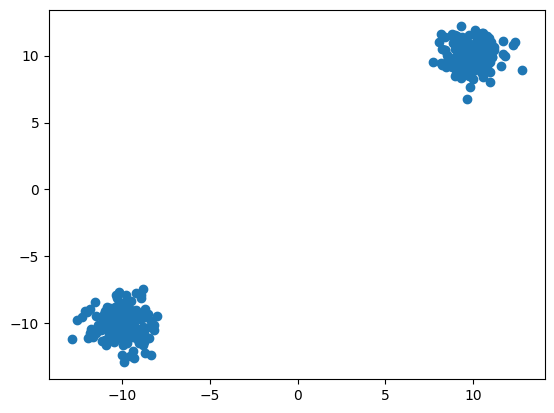

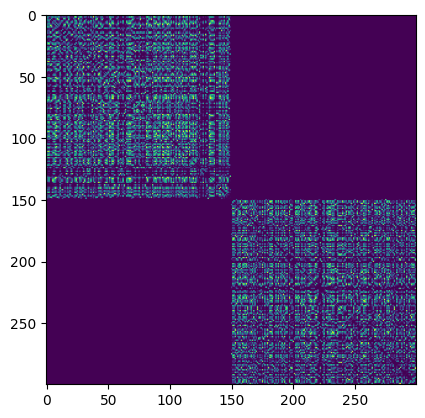

In [11]:
#plot data in r^2 space
plt.scatter(data[:, 0], data[:, 1])
#plot kernel matrix
plt.figure()
plt.imshow(K)

In [13]:
#Compute Probability that y_m = 0 given y_1 ... y_m-1
def compute_p(K, y_known, temp):
    #if y_m = 1
    y_tmp = np.vstack([y_known, [1, 0]])
    m = len(y_tmp)
    G = 0.5*(np.eye(n) + np.ones((n,n)))
    G[:m, :m] = y_tmp @ y_tmp.T
    mass_1 = np.trace(G @ K)**temp

    #if y_m = 0
    y_tmp = np.vstack([y_known, [0, 1]])
    m = len(y_tmp)
    G = 0.5*(np.eye(n) + np.ones((n,n)))
    G[:m, :m] = y_tmp @ y_tmp.T
    mass_0 = np.trace(G @ K)**temp
    
    def boost_probs_sigmoid(probs, steepness=1.0, center=0.5):
        # Shifted sigmoid function: 1 / (1 + exp(-steepness * (x - center)))
        boosted = 1 / (1 + np.exp(-steepness * (probs - center)))
        
        # Normalize to ensure they still sum to 1
        return boosted / boosted.sum()
    p = mass_0 / (mass_0 + mass_1)
    p = boost_probs_sigmoid(np.array([p, 1-p]) , steepness=10000.0, center=0.5)[0]
    return p

100%|██████████| 299/299 [00:00<00:00, 440.53it/s]


0.41


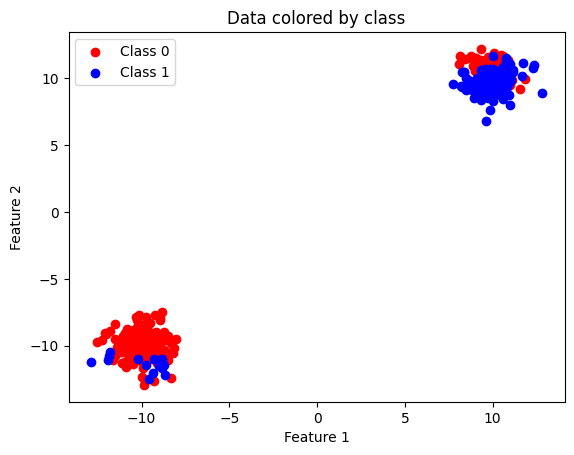

In [14]:
#Probabilistic Binary Tree Search to Sample
u = np.random.rand(1)
y_0 = (u < 0.5).astype(int)

known_y = np.eye(2)[np.array([y_0])]
known_y = known_y.reshape(1, 2)

for i in trange(1, n):
    p = compute_p(K, known_y, 1)
    #print(p)
    u = np.random.rand(1)
    y_i = (u < p).astype(int)
    next_y = np.eye(2)[np.array([y_i])]
    next_y = next_y.reshape(1, 2)
    known_y = np.vstack([known_y, next_y])

Y = known_y[:,0]
print(np.count_nonzero(Y) / n)
plt.scatter(data[Y.flatten() == 0, 0], data[Y.flatten() == 0, 1], color='red', label='Class 0')
plt.scatter(data[Y.flatten() == 1, 0], data[Y.flatten() == 1, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Data colored by class')
plt.show()

In [15]:
known_y @ known_y.T
#svd of ^
U, S, V = np.linalg.svd(known_y @ known_y.T)

100%|██████████| 299/299 [00:00<00:00, 351.88it/s]


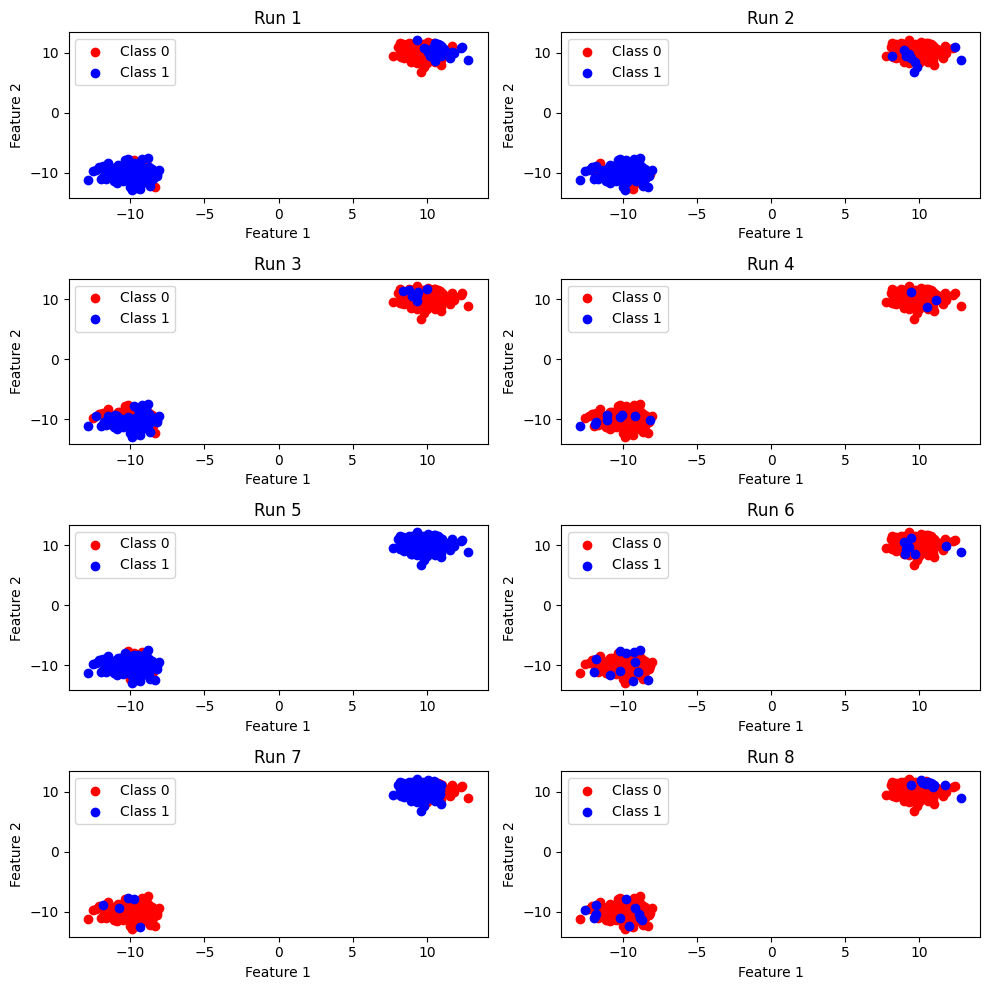

In [16]:
m = 8
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

for j in range(m):
    u = np.random.rand(1)
    y_0 = (u < 0.5).astype(int)

    known_y = np.eye(2)[np.array([y_0])]
    known_y = known_y.reshape(1, 2)

    for i in trange(1, n):
        p = compute_p(K, known_y, 1)
        #print(p)
        u = np.random.rand(1)
        y_i = (u < p).astype(int)
        next_y = np.eye(2)[np.array([y_i])]
        next_y = next_y.reshape(1, 2)
        known_y = np.vstack([known_y, next_y])

    Y_run = known_y[:,0]
    
    ax = axes[j // 2, j % 2]
    ax.scatter(data[Y_run == 0, 0], data[Y_run == 0, 1], color='red', label='Class 0')
    ax.scatter(data[Y_run == 1, 0], data[Y_run == 1, 1], color='blue', label='Class 1')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.set_title(f'Run {j+1}')

plt.tight_layout()
plt.show()


In [18]:
known_y @ known_y.T
#svd of ^
U, S, V = np.linalg.svd(known_y @ known_y.T)
U[:2].shape

(2, 300)